In [17]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import glob
import shutil
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential

In [ ]:
# Structure data as required by keras.utils.image_dataset_from_directory
image_directory = 'data/cifar-10/train'
structured_train_directory = 'data/cifar-10/structured_train/'
labels_csv = 'data/cifar-10/trainLabels.csv'
df = pd.read_csv(labels_csv)
df.head()

for index, row in df.iterrows():
    image_id = row['id']
    label = row['label']

    # Create the target directory if it doesn't exist
    target_directory = os.path.join(structured_train_directory, label)
    #os.makedirs(target_directory, exist_ok=True)

    # Build the source and destination file paths
    source_image_path = os.path.join(image_directory, f'{image_id}.png')
    destination_image_path = os.path.join(target_directory, f'{image_id}.png')

    # Copy the image to the structured_train directory
    #shutil.copy(source_image_path, destination_image_path)

In [18]:
# Generate the dataset
img_height = 32
img_width = 32
batch_size = 16

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data/cifar-10/structured_train/",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Using 10000 files for validation.


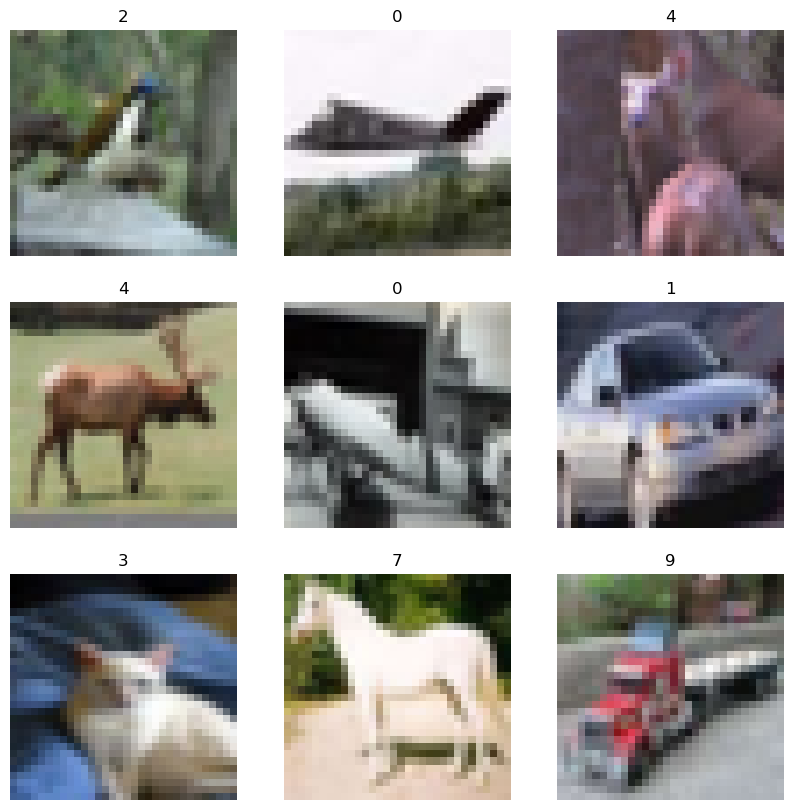

In [13]:
# Visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [16]:
# display the shape of the tensors
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
# (16 images, 32x32 pixels, 3 colour channels)
# (16 labels)

(16, 32, 32, 3)
(16,)


In [20]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data - RGB channel values from [0, 255] is not ideal -> standardize to [0, 1]
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [23]:
# Creating a model
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [28]:
# Compiling
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 64)         

In [29]:
# Training
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2500/2500 [==============================] - 32s 13ms/step - loss: 0.7583 - accuracy: 0.7317 - val_loss: 0.8793 - val_accuracy: 0.6988
Epoch 2/10
2500/2500 [==============================] - 30s 12ms/step - loss: 0.7047 - accuracy: 0.7494 - val_loss: 0.8211 - val_accuracy: 0.7158
Epoch 3/10
2500/2500 [==============================] - 32s 13ms/step - loss: 0.6709 - accuracy: 0.7615 - val_loss: 0.8093 - val_accuracy: 0.7207
Epoch 4/10
2500/2500 [==============================] - 31s 12ms/step - loss: 0.6283 - accuracy: 0.7766 - val_loss: 0.8123 - val_accuracy: 0.7249
Epoch 5/10
2500/2500 [==============================] - 30s 12ms/step - loss: 0.5944 - accuracy: 0.7898 - val_loss: 0.8443 - val_accuracy: 0.7195
Epoch 6/10
2500/2500 [==============================] - 32s 13ms/step - loss: 0.5583 - accuracy: 0.8011 - val_loss: 0.8524 - val_accuracy: 0.7198
Epoch 7/10
2500/2500 [==============================] - 30s 12ms/step - loss: 0.5295 - accuracy: 0.8103 - val_loss: 0.8509 -

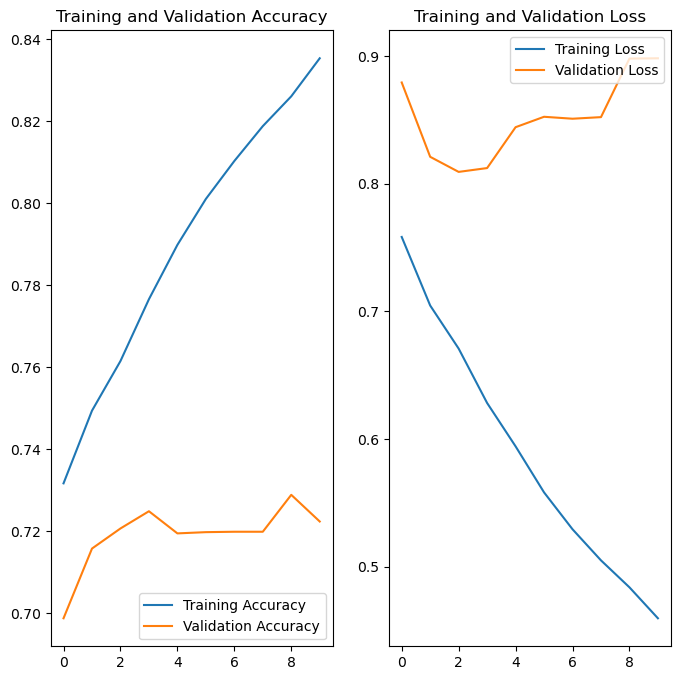

In [30]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# The training accuracy reaches over 80%, and validation just over 70%.

In [32]:
m = tf.keras.metrics.Precision()
m.update_state([0, 1, 1, 1], [1, 0, 1, 1])
m.result().numpy()

NameError: name 'y_true' is not defined

In [10]:
# Addressing overfitting with simple data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [11]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [13]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

input_shape = (None, 32, 32, 3)
model.build(input_shape) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                 

In [14]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


KeyboardInterrupt: 